# Collect pulse and vibration shapes for averaging and plotting

Author: Bjarne Schultze <br>
Last modified: 29.11.2024

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb


import modules.analysis_utils as utils
import modules.data_handling_utils as dutils
import modules.plotting_utils as myplt
plt.style.use('./plotstyle_bjarne.mplstyle')

In [2]:
# Define colors
vib_col = to_rgb("#04A83D")   # '#46A81F'
pulse_col = to_rgb("#ff0000")  # '#5D11AD' 
sine_col = to_rgb("#2d7cff")  # '#F07236' 
sine_col_light = to_rgb("#78CEFF")
pulse_col_light = to_rgb("#FF776F")
vib_col_light = to_rgb("#7DD189")

In [3]:
# Choose an experimental group
exp_grp = "TN1A" 

# Create a dictionary mapping experimental group and genotype in the meta data table
genotype_dict = {"pIP10": "CsChrimson; VT40556", "TN1A": "TN1A_CsChrimson", "vPR13": "vPR13_CsChrimson", 
                 "vMS12-SS3": "vMS12-SS3_CsChrimson", "CsChrimson_ctrl": "CsChrimson", "vPR13_ctrl": "vPR13"}

# Set the main result path
main_path = "E:/res/"
# Set the path to the metadata file
metadata_path = "E:/MT/additional_files/metadata.pkl"

# Load metadata file (first five files with different protocol are missing)
metadata = pd.read_pickle(metadata_path)

# Extract the experiment names for the current neuron type
exp = metadata.loc[metadata["genotype"] == genotype_dict[exp_grp], :]
experiments = exp.loc[exp["individuals.1"].isna(), "filename"].to_list()
experiments_mf = exp.loc[exp["individuals.1"] == "1", "filename"].to_list()

In [4]:
# Load the annotations for the male-female and solitary condition
annotations_mf, stim_ons_mf, stim_offs_mf, stim_volts_mf, bad_files = dutils.load_annotations(experiments_mf, main_path=main_path, metadata_path=metadata_path)
annotations, stim_ons, stim_offs, stim_volts, _ = dutils.load_annotations(experiments, main_path=main_path, metadata_path=metadata_path)

# Remove bad files from experiment list
if len(bad_files) > 0:
    [ experiments_mf.remove(bf) for bf in bad_files ]

# Calculate the stimulus length
stim_len = stim_offs[0][0] - stim_ons[0][0]

# Extract the sampling rate
sampling_rate = metadata["sampling_rate"][5]

Skipped experiment localhost-20240325_085619! Incomplete stimulus set before copulation.
Skipped experiment localhost-20240325_093502! Incomplete stimulus set before copulation.


In [ ]:
# Lists to store the cutouts
all_vib_sections = []
all_pulse_sections = []

# Iterate over the experiments and corresponding annotations
for file, ann in zip(experiments_mf, annotations_mf):
    # Load data + bandpass filter song
    filepath = f"E:/dat/{file}/{file}_daq.h5"
    dataset, sampling_r = dutils.load_dataset(filepath, filter=True)

    # Make cutouts of all pulses
    p_times = ann.loc[ann['name']=='pulse_manual','start_seconds'].to_numpy()
    p_sections_norm, section_time = utils.cut_events(dataset, p_times, norm=True)
    # Make cutouts of all vibrations
    vib_times = ann.loc[ann['name']=='vibration_manual','start_seconds'].to_numpy()
    vib_sections_norm, section_time_v = utils.cut_events(dataset, vib_times, norm=True)
    # Store the cutouts
    all_vib_sections.append(p_sections_norm)
    all_pulse_sections.append(vib_sections_norm)

Loading file: E:/dat/localhost-20240315_101006/localhost-20240315_101006_daq.h5
Filtering channels 0 to 15
Loading file: E:/dat/localhost-20240318_093453/localhost-20240318_093453_daq.h5
Filtering channels 0 to 15
Loading file: E:/dat/localhost-20240419_092409/localhost-20240419_092409_daq.h5
Filtering channels 0 to 15
Loading file: E:/dat/localhost-20240419_095625/localhost-20240419_095625_daq.h5
Filtering channels 0 to 15
Loading file: E:/dat/localhost-20240527_084245/localhost-20240527_084245_daq.h5
Filtering channels 0 to 15
Loading file: E:/dat/localhost-20240527_091508/localhost-20240527_091508_daq.h5
Filtering channels 0 to 15
Loading file: E:/dat/localhost-20240527_094737/localhost-20240527_094737_daq.h5
Filtering channels 0 to 15
Loading file: E:/dat/localhost-20240527_101953/localhost-20240527_101953_daq.h5
Filtering channels 0 to 15


In [27]:
# Stack pulse and vibration cutouts 
all_pulse_sections_a = np.vstack(all_pulse_sections)
all_vib_sections_a = np.vstack(all_vib_sections)

# Average over all cutouts
avg_pshape = np.mean(all_pulse_sections_a, axis=0)
avg_vibshape = np.mean(all_vib_sections_a, axis=0)
# Standard deviation over all cutouts
std_pshape = np.std(all_pulse_sections_a, axis=0)
std_vibshape = np.std(all_vib_sections_a, axis=0)

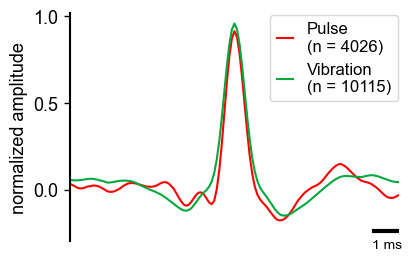

In [44]:
# New figure
fig, ax = plt.subplots(1, 1, figsize=(4,2.5))

# Plot average pulse and vibration shapes
ax.plot(section_time, avg_pshape, label=f'Pulse\n(n = {all_pulse_sections_a.shape[0]})', color=pulse_col)
ax.plot(section_time_v, avg_vibshape, label=f'Vibration\n(n = {all_vib_sections_a.shape[0]})', color=vib_col)

# Adjust x axis, add legend
ax.set_xlim((-6.5, 6.5))
myplt.axis_to_scale(ax, "ms", 1, txt_offset=0.05, linewidth=3)
ax.legend()

# Adjust y axis
ax.set_ylabel('normalized amplitude')
ax.set_yticks([0,0.5,1])

# Save figure
fig.savefig("../figures_wip/pulse_vib_example.pdf")